In [1]:
import numpy as np
import pandas as pd 
import matplotlib 
import matplotlib .pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly as py
import os

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import flatten, udf, col
from pyspark.sql.types import BooleanType
bucket = 'apy_bucket1'
spark = SparkSession.builder\
    .appName("pyspark-test")\
    .config("spark.jars", "gs://spark-lib/bigquery/spark-bigquery-latest.jar")\
    .getOrCreate()

df = spark.read \
    .format("bigquery") \
    .load('fresh-booster-386408.dataset.APY').cache()
df.show(3)

In [ ]:
+----+--------------------+---------+--------+---------+-----------+------+----------+-----+
|Slno|               State|District_|    Crop|Crop_Year|     Season| Area_|Production|Yield|
+----+--------------------+---------+--------+---------+-----------+------+----------+-----+
|   2|Andaman and Nicob...| NICOBARS|Arecanut|     2008|Autumn     |4147.0|      3060| 0.74|
|   4|Andaman and Nicob...| NICOBARS|Arecanut|     2009|Autumn     |4153.0|      3120| 0.75|
|  67|Andaman and Nicob...| NICOBARS|  Banana|     2008|Autumn     | 795.0|      7710|  9.7|
+----+--------------------+---------+--------+---------+-----------+------+----------+-----+
only showing top 3 rows

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = pd.read_csv("/content/drive/My Drive/input_APY.csv")
dataset.head(5)

,Slno,State,District,Crop,Crop_Year,Season,Area,Production,Yield
0,0,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Kharif,2439.6,3415,1.40
1,1,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Rabi,1626.4,2277,1.40
2,2,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Autumn,4147.0,3060,0.74
3,3,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Summer,4147.0,2660,0.64
4,4,Andaman and Nicobar Island,NICOBARS,Arecanut,2009,Autumn,4153.0,3120,0.75


In [4]:
dataset.columns

Index(['Slno', 'State', 'District ', 'Crop', 'Crop_Year', 'Season', 'Area ',
       'Production', 'Yield'],
      dtype='object')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267369 entries, 0 to 267368
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Slno        267369 non-null  int64  
 1   State       267369 non-null  object 
 2   District    267369 non-null  object 
 3   Crop        267369 non-null  object 
 4   Crop_Year   267369 non-null  int64  
 5   Season      267369 non-null  object 
 6   Area        267369 non-null  float64
 7   Production  267369 non-null  int64  
 8   Yield       267369 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 18.4+ MB


In [6]:
dataset.describe()

,Slno,Crop_Year,Area,Production,Yield
count,267369.000000,267369.000000,2.673690e+05,2.673690e+05,267369.000000
mean,133684.000000,2008.926671,1.054374e+04,1.193378e+06,85.588530
std,77182.926399,6.613316,3.573092e+04,2.428271e+07,958.852792
min,0.000000,1997.000000,8.000000e-03,0.000000e+00,0.000000
25%,66842.000000,2003.000000,7.000000e+01,8.000000e+01,0.600000
50%,133684.000000,2009.000000,5.060000e+02,6.780000e+02,1.100000
75%,200526.000000,2015.000000,3.788000e+03,6.462000e+03,2.670000
max,267368.000000,2020.000000,1.133397e+06,1.597800e+09,38800.000000


In [7]:
dataset.isnull().sum()

Slno          0
State         0
District      0
Crop          0
Crop_Year     0
Season        0
Area          0
Production    0
Yield         0
dtype: int64

In [8]:
temp = dataset.groupby(by='Crop')['Production'].sum().reset_index().sort_values(by='Production')
px.bar(temp.tail(), 'Crop', 'Production')

In [9]:
temp = dataset.groupby(by='State')['Production'].sum().reset_index().sort_values(by='Production')
px.bar(temp, 'State', 'Production',color = 'State')

In [10]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 5 to 15
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   State       34 non-null     object
 1   Production  34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 816.0+ bytes


In [11]:
dataset['Area ']

0         2439.6
1         1626.4
2         4147.0
3         4147.0
4         4153.0
           ...  
267364     855.0
267365    1366.0
267366    1052.0
267367     833.0
267368     516.0
Name: Area , Length: 267369, dtype: float64

In [12]:
temp = dataset.groupby('State')['Area ','Production'].sum().reset_index()
temp['Production_Per_Unit_Area'] = temp['Production']/temp['Area ']
temp = temp.sort_values(by='Production_Per_Unit_Area')
px.bar(temp, 'State', 'Production_Per_Unit_Area', color='Production_Per_Unit_Area', )

<ipython-input-12-e2bd0ff9c477>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [13]:
temp = dataset.groupby(by='Crop_Year')['Production'].sum().reset_index()
px.line(temp, 'Crop_Year', 'Production')

In [14]:
temp = dataset.groupby(by='Crop_Year')['Area '].mean().reset_index()
px.scatter(temp, 'Crop_Year', 'Area ', color='Area ', size='Area ')

In [27]:
dataset

,Slno,State,District,Crop,Crop_Year,Season,Area,Production,Yield
0,0,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Kharif,2439.6,3415,1.40
1,1,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Rabi,1626.4,2277,1.40
2,2,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Autumn,4147.0,3060,0.74
3,3,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Summer,4147.0,2660,0.64
4,4,Andaman and Nicobar Island,NICOBARS,Arecanut,2009,Autumn,4153.0,3120,0.75
...,...,...,...,...,...,...,...,...,...
267364,267364,West Bengal,PURULIA,Wheat,2015,Rabi,855.0,1241,1.45
267365,267365,West Bengal,PURULIA,Wheat,2016,Rabi,1366.0,2415,1.77
267366,267366,West Bengal,PURULIA,Wheat,2017,Rabi,1052.0,2145,2.04
267367,267367,West Bengal,PURULIA,Wheat,2018,Rabi,833.0,2114,2.54


(array([104628.,      0.,  77980.,      0.,   6079.,      0.,  18456.,
             0.,  52643.,   7583.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

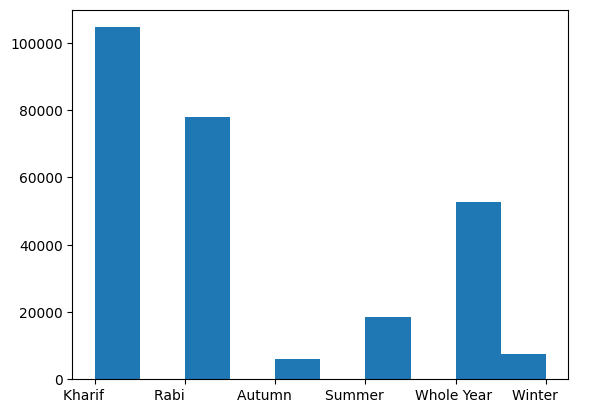

In [29]:
plt.hist(dataset['Season'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '1997'),
  Text(1, 0, '1998'),
  Text(2, 0, '1999'),
  Text(3, 0, '2000'),
  Text(4, 0, '2001'),
  Text(5, 0, '2002'),
  Text(6, 0, '2003'),
  Text(7, 0, '2004'),
  Text(8, 0, '2005'),
  Text(9, 0, '2006'),
  Text(10, 0, '2007'),
  Text(11, 0, '2008'),
  Text(12, 0, '2009'),
  Text(13, 0, '2010'),
  Text(14, 0, '2011'),
  Text(15, 0, '2012'),
  Text(16, 0, '2013'),
  Text(17, 0, '2014'),
  Text(18, 0, '2015'),
  Text(19, 0, '2016'),
  Text(20, 0, '2017'),
  Text(21, 0, '2018'),
  Text(22, 0, '2019'),
  Text(23, 0, '2020')])

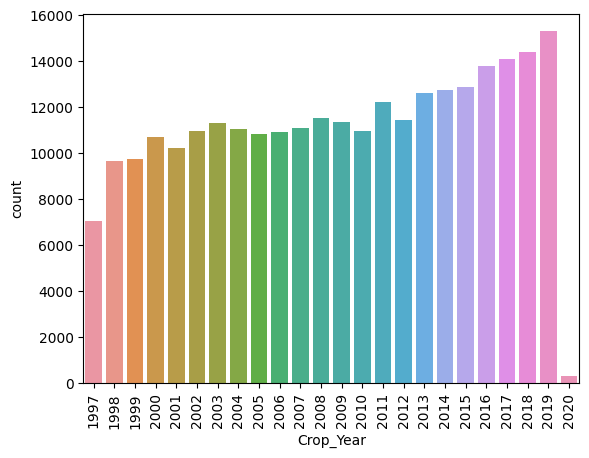

In [31]:
sns.countplot(x=dataset['Crop_Year'])
plt.xticks(rotation=90)